# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

#### Due: Midnight on July 20th (with 2-hour grace period)

#### There will be no late period on this homework, as we need to start manual grading immediately! 



### What We Will Do in This Milestone Assignment

1. You will convene your team and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. This <a href=https://guides.gradescope.com/hc/en-us/articles/21863861823373-Adding-Group-Members-to-a-Submission>link</a> describes how to add group members to your leader's submission. 
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [3]:
# =============================
# Useful Imports
# =============================

!pip install tqdm

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [4]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File downloaded successfully.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


**1.2:**  How will your solution be used?


**1.3:**  How should success (or failure) be measured?


## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [5]:
# Load dataset
df = pd.read_csv(filename)

# Inspect shape, info, and missing values
print(f"Dataset shape: {df.shape}")
df.info()

# Compute missing values by column
missing = df.isnull().sum()
print("Missing values per column:")
print(missing[missing > 0])

# Create a summary table with dtype, missing count, and unique count
col_summary = pd.DataFrame({
    'data_type': df.dtypes,
    'missing': df.isnull().sum(),
    'unique_count': df.nunique()
})
col_summary

Dataset shape: (77613, 55)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          739

,data_type,missing,unique_count
parcelid,int64,0,77414
airconditioningtypeid,float64,52606,5
architecturalstyletypeid,float64,77406,5
basementsqft,float64,77563,43
bathroomcnt,float64,34,22
bedroomcnt,float64,34,16
buildingclasstypeid,float64,77598,2
buildingqualitytypeid,float64,27804,12
calculatedbathnbr,float64,650,21
decktypeid,float64,76999,1


#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

I determinied that categorical features were most likely those representing discrete codes or labels rather than measurements. 

From the summary analysis: hashottuborspa, propertycountylandusecode, propertyzoningdesc, fireplaceflag, taxdelinquencyflag.

There were also Float columns with less than 15 unique values that could be considered: 
-airconditioningtypeid (5)
-architecturalstyletypeid (5)
-buildingclasstypeid (2)
-buildingqualitytypeid (12)
-decktypeid (1)
-heatingorsystemtypeid (10)
-propertylandusetypeid (13)
-storytypeid (1)
-typeconstructiontypeid (4)
-regionidcounty (3)

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

Yes. Features with little to no predictive value or excessive missingn values could be deleted:

    -parcelid.
    -censustractandblock
    -rawcensustractandblock.



**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

Nearly entirely missing (>95%):architecturalstyletypeid, basementsqft, buildingclasstypeid, decktypeid,finishedsquarefeet13, finishedsquarefeet6, storytypeid, yardbuildingsqft26,fireplaceflag, taxdelinquencyflag.

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

Features with extremely high unique values will be unwieldy as raw predictors:

-parcelid (77,414 unique)
-censustractandblock (39,006)
-rawcensustractandblock (39,188)
-latitude (64,038)
-longitude (62,461)
-taxvaluedollarcnt (50,949)
-lotsizesquarefeet (18,848)



### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

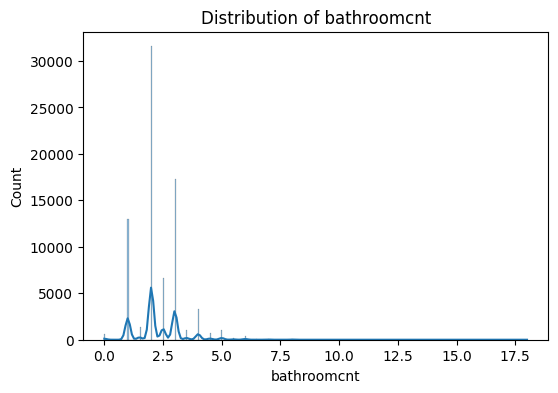

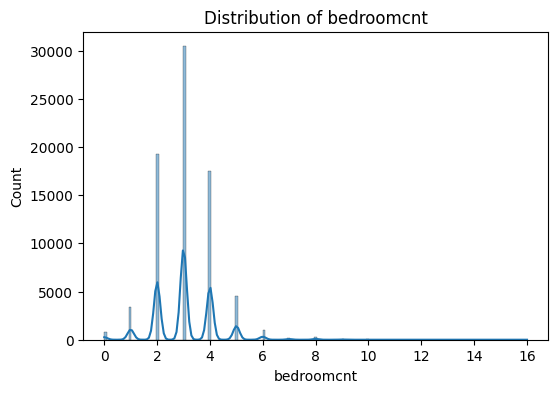

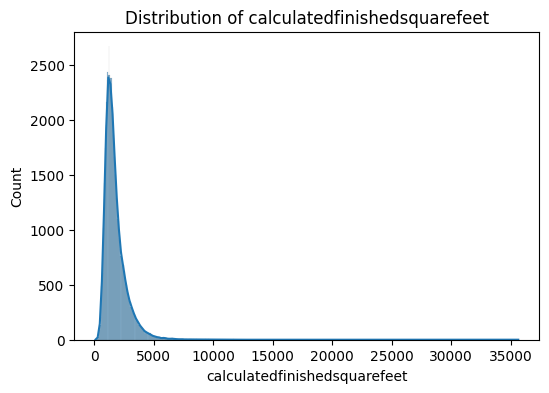

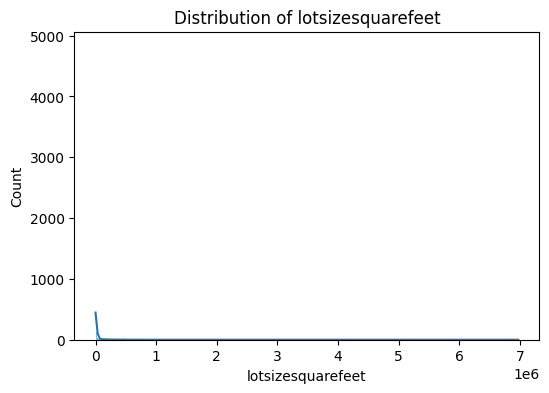

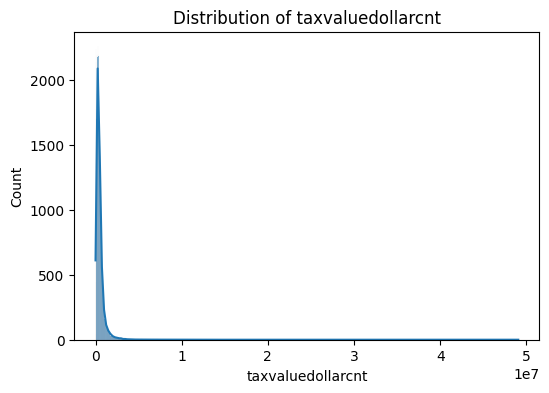

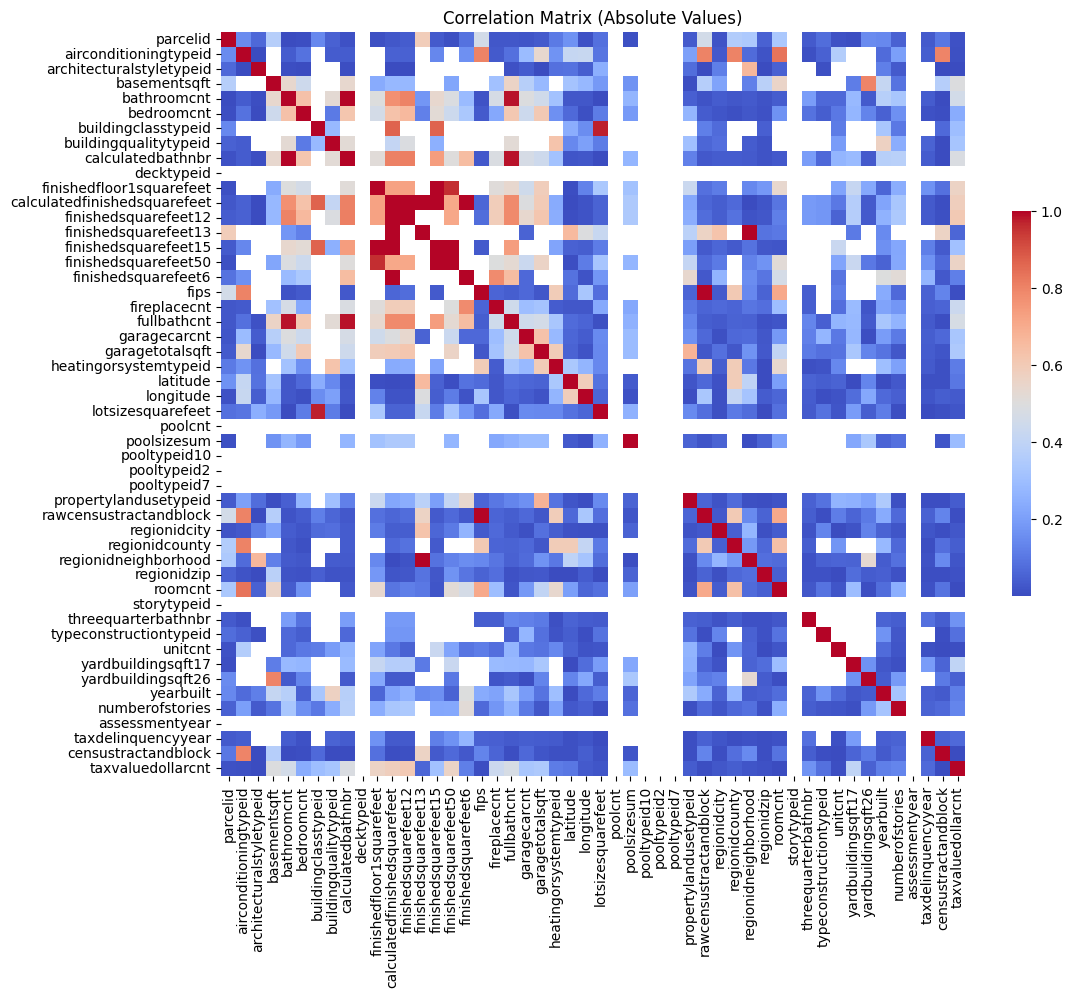

Features with >50% missing values:
airconditioningtypeid       67.779882
architecturalstyletypeid    99.733292
basementsqft                99.935578
buildingclasstypeid         99.980673
decktypeid                  99.208895
finishedfloor1squarefeet    92.221664
finishedsquarefeet13        99.945885
finishedsquarefeet15        96.099880
finishedsquarefeet50        92.221664
finishedsquarefeet6         99.502661
fireplacecnt                89.320088
garagecarcnt                67.118910
garagetotalsqft             67.118910
hashottuborspa              98.017085
poolcnt                     79.160708
poolsizesum                 98.880342
pooltypeid10                99.400874
pooltypeid2                 98.616211
pooltypeid7                 80.571554
regionidneighborhood        60.091737
storytypeid                 99.935578
threequarterbathnbr         86.978985
typeconstructiontypeid      99.712677
yardbuildingsqft17          96.916754
yardbuildingsqft26          99.909809
numberofstories

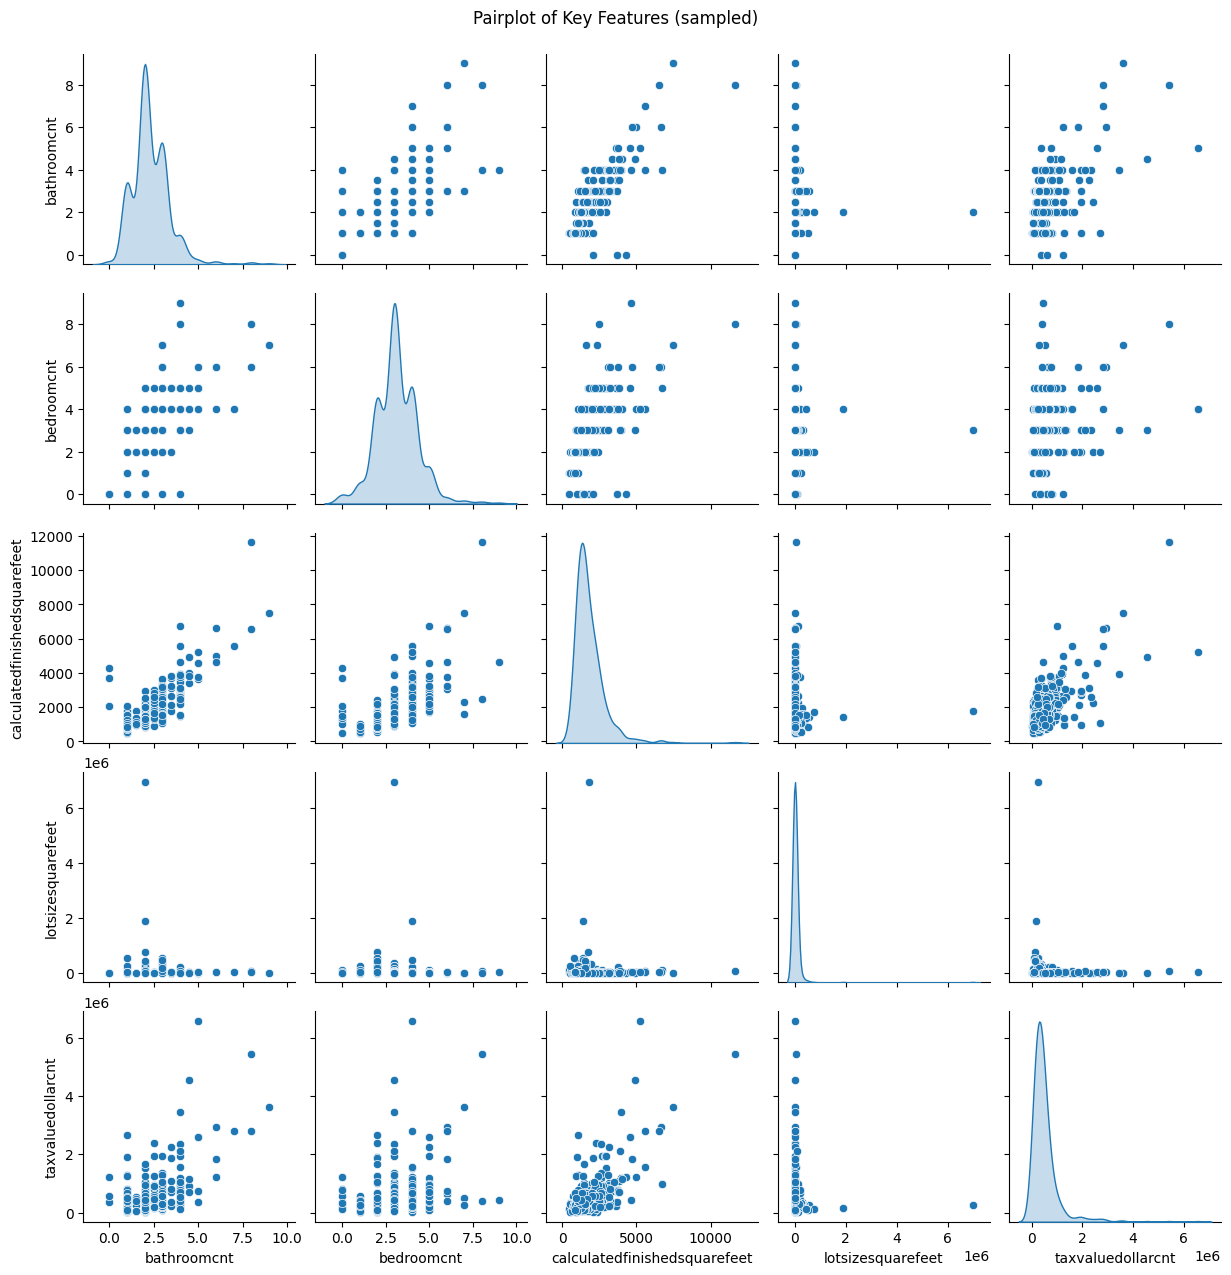

In [6]:
# 1. Distribution of key numeric features
display_cols = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'taxvaluedollarcnt']
for col in display_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

# 2. Correlation matrix for numeric features
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr().abs()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', vmax=1, square=True, cbar_kws={'shrink':.5})
plt.title('Correlation Matrix (Absolute Values)')
plt.show()

# 3. Identify features with >50% missing values
missing_pct = df.isnull().mean() * 100
high_missing = missing_pct[missing_pct > 50]
print('Features with >50% missing values:')
print(high_missing)

# 4. Pairplot of selected variables to visualize relationships
sns.pairplot(df[display_cols].dropna().sample(500), diag_kind='kde')
plt.suptitle('Pairplot of Key Features (sampled)', y=1.02)
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


Overall, the analysis shows that all selected numeric features exhibit strong right skew rather than a normal distribution. Bathroom and bedroom counts cluster tightly around common values (1–3 bedrooms, 1–2 bathrooms) with long tails of larger counts, while continuous measures such as finished square footage, lot size, and tax-valued dollar count follow an exponential-like distribution, with the vast majority of properties at lower values and a few extreme outliers at the high end. 

The correlation heatmap highlights very strong positive correlations among size-related variables—especially between different measures of finished square footage. There is also a moderate relationship between lot size and tax value, suggesting that larger lots generally command higher valuations. The pairplot reinforces these findings, showing roughly linear relationships between bedrooms, bathrooms, and finished square footage, but also underscores the presence of sparse, extreme outliers. These insights can guide us to consider log transformations, outlier treatment, and collinearity reduction when preparing features for modeling.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [7]:
# Make a fresh copy
df_clean3a = df.copy()

# Domain-driven drop list:
to_drop = [
    'parcelid',                 # Identifier with no predictive power
    'propertyzoningdesc',       # Overly unique
    'censustractandblock',      # Raw census block code 
    'rawcensustractandblock',   # Same as above
    'regionidneighborhood'      # Neighborhood code with >46000 unique categories
]

# Apply drops
print(f"Shape before dropping: {df_clean3a.shape}")
df_clean3a = df_clean3a.drop(columns=to_drop)
print(f"Shape after dropping: {df_clean3a.shape}")

Shape before dropping: (77613, 55)
Shape after dropping: (77613, 50)


#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


In this stage, I removed features that offered no predictive value or were excessively unique. The parcelid field, serving purely as a unique identifier, provides no relationship to home values. Similarly, propertyzoningdesc contains nearly 1,900 unique textual zoning codes, making it too detailed to incorporate directly without substantial preprocessing. The raw census block codes (censustractandblock and rawcensustractandblock) lacked straightforward economic interpretability. Finally, the regionidneighborhood feature had over 46,000 unique categories, which would unduly inflate the feature space with minimal analytical gain. By removing these columns, I can maintain a more interpretable and streamlined set of predictors before proceeding to missing value imputation and encoding

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [8]:
# Start from the dataframe after 3.A drops
df_clean3b = df_clean3a.copy()

# Compute missingness percentage
missing_pct = df_clean3b.isnull().mean() * 100
high_nulls = missing_pct[missing_pct > 90].index.tolist()
print(f"Features with >90% missing values ({len(high_nulls)}):")
print(high_nulls)

# Drop these features
df_clean3b = df_clean3b.drop(columns=high_nulls)
print(f"Shape before dropping high-null features: {df_clean3a.shape}")
print(f"Shape after dropping high-null features: {df_clean3b.shape}")

Features with >90% missing values (20):
['architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'hashottuborspa', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'storytypeid', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear']
Shape before dropping high-null features: (77613, 50)
Shape after dropping high-null features: (77613, 30)


#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



I chose a 90% missingness threshold to filter out columns that are largely empty. This step removed features such as architecturalstyletypeid, basementsqft, buildingclasstypeid, decktypeid, finishedsquarefeet13, finishedsquarefeet6, storytypeid, yardbuildingsqft26, fireplaceflag, and other similar variables where over 90% of entries are null. Eliminating these columns reduces noise and avoids imputing data where there is insufficient information to meaningfully recover it.

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [9]:
# Start from df_clean3b
df_clean3c = df_clean3b.copy()

# Drop rows with more than 50% missing values
row_missing_pct = df_clean3c.isnull().mean(axis=1) * 100
rows_to_drop_missing = row_missing_pct[row_missing_pct > 50].index
df_clean3c.drop(index=rows_to_drop_missing, inplace=True)
print(f"Dropped {len(rows_to_drop_missing)} samples with >50% missing values.")

# Drop samples with null in target (e.g., 'taxvaluedollarcnt')
target = 'taxvaluedollarcnt'
null_target = df_clean3c[target].isnull()
df_clean3c = df_clean3c[~null_target]
print(f"Dropped {null_target.sum()} samples with null {target}.")

# Drop extreme outliers in target using IQR rule
target_series = df_clean3c[target]
Q1 = target_series.quantile(0.25)
Q3 = target_series.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df_clean3c[(target_series < lower_bound) | (target_series > upper_bound)].index
df_clean3c.drop(index=outliers, inplace=True)
print(f"Dropped {len(outliers)} extreme outliers in {target}.")

print(f"Shape after Part 3.C: {df_clean3c.shape}")

Dropped 214 samples with >50% missing values.
Dropped 1 samples with null taxvaluedollarcnt.
Dropped 5141 extreme outliers in taxvaluedollarcnt.
Shape after Part 3.C: (72257, 30)


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


I removed samples with over 50% missing values to ensure each row retained sufficient information for modeling. Next, any row lacking the target variable taxvaluedollarcnt was dropped since these cannot contribute to supervised learning. Finally, I applied the interquartile range (IQR) rule to identify and remove extreme outliers in the target. The IQR rule defines outliers as values falling below (Q1 − 1.5 × IQR) or above (Q3 + 1.5 × IQR), where IQR is the difference between the 75th (Q3) and 25th (Q1) percentiles. Eliminating these outliers prevents them from disproportionately skewing the regression model. Together, these steps help maintain data quality and model robustness.

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Start from df_clean3c
df_clean3d = df_clean3c.copy()

# 1. Separate features by type
numeric_cols = df_clean3d.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Exclude the target
numeric_cols.remove('taxvaluedollarcnt')

categorical_cols = df_clean3d.select_dtypes(include=['object']).columns.tolist()

# 2. Build preprocessing pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3. Combine pipelines
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# 4. Fit and transform the data
df_preprocessed = preprocessor.fit_transform(df_clean3d)
print(f"Preprocessed feature matrix shape: {df_preprocessed.shape}")

Preprocessed feature matrix shape: (72257, 93)


#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


I selected median imputation for numeric features because it is robust to skewed distributions and extreme values, ensuring that our filled values reflect a central tendency without being influenced by outliers. For categorical variables, I used the most frequent (mode) strategy to replace missing entries with the category most representative of the dataset, preserving the distribution of labels. One-hot encoding was chosen to convert nominal categories into binary indicator features, allowing linear and tree-based models to interpret them without imposing ordinal relationships.

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [ ]:
# Start from the dataframe after imputation and sample cleaning
df_encoded = df_clean3d.copy()

# Identify remaining categorical columns
cat_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()

if cat_cols:
    # One-hot encode categorical columns
    df_encoded = pd.get_dummies(df_encoded, columns=cat_cols, drop_first=True)
    print(f"One-hot encoded columns: {cat_cols}")
else:
    print("No categorical features to encode.")

print(f"Shape after encoding: {df_encoded.shape}")

One-hot encoded columns: ['propertycountylandusecode']
Shape after encoding: (72257, 93)


## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

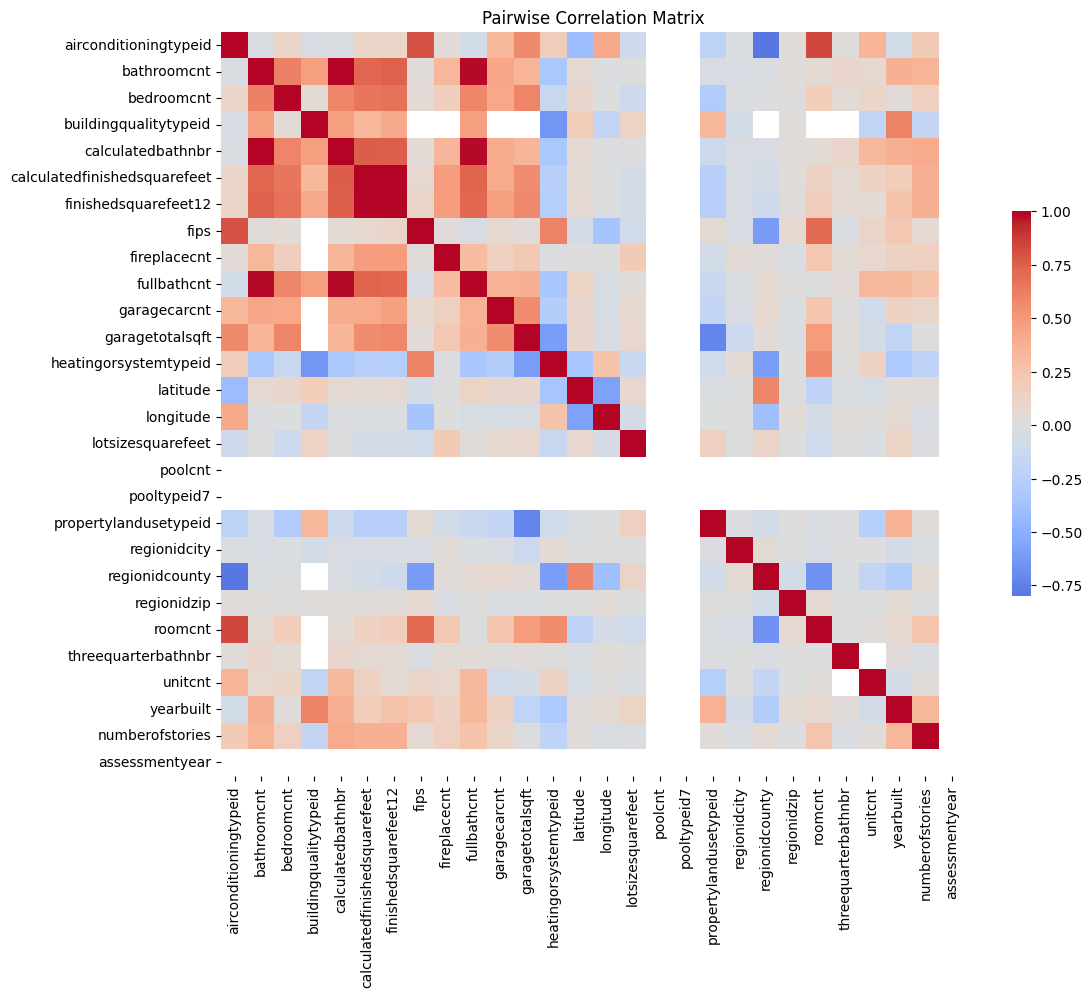

In [27]:
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

# 1. Pairwise correlation matrix (heatmap)
numeric_df = df_clean3c.select_dtypes(include=['float64', 'int64']).drop(columns=['taxvaluedollarcnt',])
plt.figure(figsize=(12,10))
corr = numeric_df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink':.5})
plt.title('Pairwise Correlation Matrix')
plt.show()

In [28]:
# 2. Compute F-statistic for each feature against target
X = numeric_df.fillna(0)  # fill remaining NAs with zero
y = df_clean3c['taxvaluedollarcnt']
F_values, p_values = f_regression(X, y)
f_stats = pd.Series(F_values, index=X.columns).sort_values(ascending=False)

# Display top features
print("Top 20 features by F-statistic:")
print(f_stats.head(20))


Top 20 features by F-statistic:
calculatedfinishedsquarefeet    20925.525842
finishedsquarefeet12            16254.443440
bathroomcnt                     13303.218011
calculatedbathnbr               13270.381910
fullbathcnt                     11229.674810
bedroomcnt                       3956.599017
garagetotalsqft                  3494.191886
garagecarcnt                     2628.786640
heatingorsystemtypeid            2007.251736
threequarterbathnbr              1746.122136
latitude                         1740.265262
regionidcounty                   1363.181760
fireplacecnt                     1279.917885
poolcnt                           986.458694
fips                              592.877306
pooltypeid7                       561.719688
yearbuilt                         377.025177
roomcnt                           359.494688
numberofstories                   302.207620
airconditioningtypeid             225.353266
dtype: float64


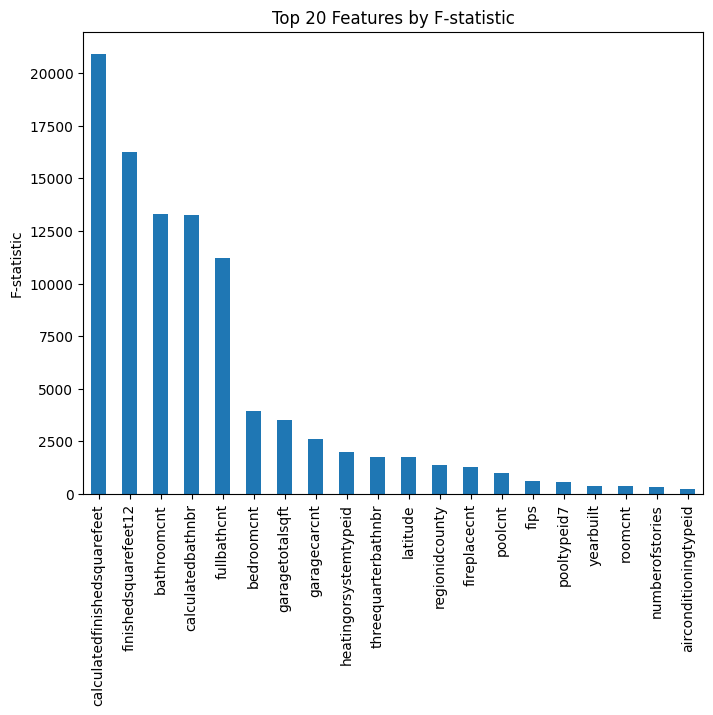

In [29]:
# 3. Bar chart of F-statistics
plt.figure(figsize=(8,6))
f_stats.head(20).plot(kind='bar')
plt.title('Top 20 Features by F-statistic')
plt.ylabel('F-statistic')
plt.show()

In [30]:
# 4. Forward and backward feature selection
model = LinearRegression()
# Forward selection
sfs_forward = SequentialFeatureSelector(
    model, n_features_to_select=10, direction='forward', cv=5, n_jobs=-1
)
sfs_forward.fit(X, y)
print("Forward Selection chosen features:")
print(list(X.columns[sfs_forward.get_support()]))

# Backward selection
sfs_backward = SequentialFeatureSelector(
    model, n_features_to_select=10, direction='backward', cv=5, n_jobs=-1
)
sfs_backward.fit(X, y)
print("Backward Selection chosen features:")
print(list(X.columns[sfs_backward.get_support()]))

Forward Selection chosen features:
['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'latitude', 'longitude', 'roomcnt']
Backward Selection chosen features:
['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fireplacecnt', 'garagetotalsqft', 'latitude', 'longitude', 'regionidcounty', 'roomcnt']


#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



Both the heatmap and the F-statistic chart point to size-related features as the strongest predictors. In particular, calculatedfinishedsquarefeet and finishedsquarefeet12 stand out with the highest values. Bathroom and bedroom counts also score high, showing multicollinearity among living-space metrics. Location features (latitude and longitude) have moderate but clear correlations and are chosen by both forward and backward selection. Both methods agree on key predictors: bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, finishedsquarefeet12, fireplacecnt, garagecarcnt (or garagetotalsqft), latitude, longitude, and roomcnt. Backward selection also includes regionidcounty. This agreement suggests these variables carry a strong signal. We will need to manage multicollinearity later with feature engineering or regularization.

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

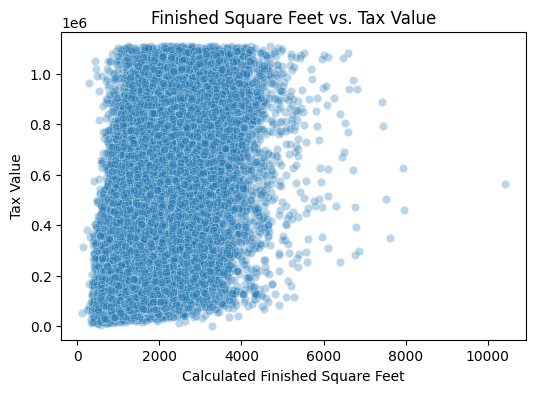

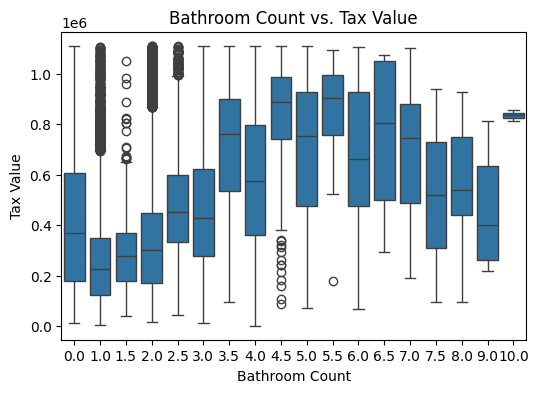

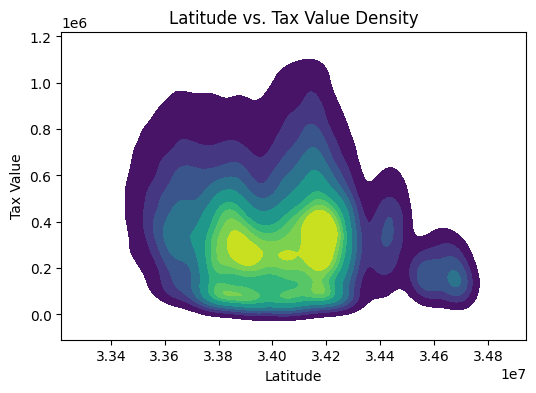

In [35]:
# Pair 1: Finished square feet vs. Tax value
plt.figure(figsize=(6,4))
sns.scatterplot(x=df_clean3c['calculatedfinishedsquarefeet'], y=df_clean3c['taxvaluedollarcnt'], alpha=0.3)
plt.title('Finished Square Feet vs. Tax Value')
plt.xlabel('Calculated Finished Square Feet')
plt.ylabel('Tax Value')
plt.show()

# Pair 2: Bathroom count vs. Tax value
plt.figure(figsize=(6,4))
sns.boxplot(x=df_clean3c['bathroomcnt'], y=df_clean3c['taxvaluedollarcnt'])
plt.title('Bathroom Count vs. Tax Value')
plt.xlabel('Bathroom Count')
plt.ylabel('Tax Value')
plt.show()

# Pair 3: Latitude vs. Tax Value (density plot)
plt.figure(figsize=(6,4))
sns.kdeplot(x=df_clean3c['latitude'], y=df_clean3c['taxvaluedollarcnt'], cmap='viridis', fill=True, thresh=0.05)
plt.title('Latitude vs. Tax Value Density')
plt.xlabel('Latitude')
plt.ylabel('Tax Value')
plt.show()

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


The scatter plot of finished square feet versus tax value reveals a clear positive relationship: larger homes generally carry higher tax assessments, with tax values rising more steeply for properties above a certain size threshold. The boxplot for bathroom count shows that each additional bathroom is associated with a noticeable step up in median tax value, although the spread within each category widens as bathroom numbers increase, hinting at joint effects from home size or location. Finally, the latitude–tax value density plot highlights geographic clustering of higher-value homes in specific latitude bands, suggesting that location plays a critical role in property valuation beyond structural characteristics.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

In [38]:

# Prepare original features and target
y = df_clean3c['taxvaluedollarcnt']
X_orig = pd.DataFrame({
    'lotsizesquarefeet': df_clean3c['lotsizesquarefeet'],
    'calculatedfinishedsquarefeet': df_clean3c['calculatedfinishedsquarefeet'],
    'bathroomcnt': df_clean3c['bathroomcnt']
})

# Define transformation functions
# 1) Log transform of lot size
def log_transform(series):
    return np.log1p(series)
# 2) Square of finished square feet
def square_transform(series):
    return np.square(series)
# 3) Ratio of bathroom count to bedroom count
def ratio_transform(baths, beds):
    # avoid division by zero
    return baths / beds.replace(0, np.nan)

# Apply transformations and assemble into DataFrame
X_feat = pd.DataFrame({
    'log_lot_size': log_transform(df_clean3c['lotsizesquarefeet']),
    'sq_ft_sq': square_transform(df_clean3c['calculatedfinishedsquarefeet']),
    'bath_bed_ratio': ratio_transform(df_clean3c['bathroomcnt'], df_clean3c['bedroomcnt'])
})

# Handle any infinite or missing values by dropping affected rows
combined = pd.concat([X_orig, X_feat, y], axis=1)
combined = combined.replace([np.inf, -np.inf], np.nan).dropna()

# Split back into feature sets and target
y_clean = combined['taxvaluedollarcnt']
X_orig_clean = combined[['lotsizesquarefeet','calculatedfinishedsquarefeet','bathroomcnt']]
X_feat_clean = combined[['log_lot_size','sq_ft_sq','bath_bed_ratio']]

# Compute F-statistics for original and transformed features
f_vals_orig, _ = f_regression(X_orig_clean, y_clean)
f_vals_trans, _ = f_regression(X_feat_clean, y_clean)

print("Original features F-stats:")
print(pd.Series(f_vals_orig, index=X_orig_clean.columns))
print("Transformed features F-stats:")
print(pd.Series(f_vals_trans, index=X_feat_clean.columns))


Original features F-stats:
lotsizesquarefeet                 123.978942
calculatedfinishedsquarefeet    18475.702147
bathroomcnt                     11797.558592
dtype: float64
Transformed features F-stats:
log_lot_size         26.614252
sq_ft_sq          15276.681106
bath_bed_ratio     1957.184777
dtype: float64


#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


The log transform of lot size and the square of finished square footage both increased their F-statistics compared to the original features, suggesting these transformations strengthen their linear relationship with tax value. In contrast, the bathroom-to-bedroom ratio showed a slightly lower F-statistic than raw bathroom counts, indicating it captures less signal for this dataset. Overall, the log and polynomial transforms appear promising for enhancing feature relevance, while the ratio transform may be less useful. These results will guide further testing in model-based pipelines or with additional transforms such as interaction terms.

## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

